<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Training-model" data-toc-modified-id="Training-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training model</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#Neural-net" data-toc-modified-id="Neural-net-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Neural net</a></span></li><li><span><a href="#Gradient-boosting" data-toc-modified-id="Gradient-boosting-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Gradient boosting</a></span></li><li><span><a href="#Evaluation-of-the-quality-of-the-forecast.-Constant-forecast." data-toc-modified-id="Evaluation-of-the-quality-of-the-forecast.-Constant-forecast.-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Evaluation of the quality of the forecast. Constant forecast.</a></span></li></ul></li><li><span><a href="#Testing-the-model" data-toc-modified-id="Testing-the-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing the model</a></span></li><li><span><a href="#General-conclusion" data-toc-modified-id="General-conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>General conclusion</a></span></li></ul></div>

#  Forecasting taxi orders

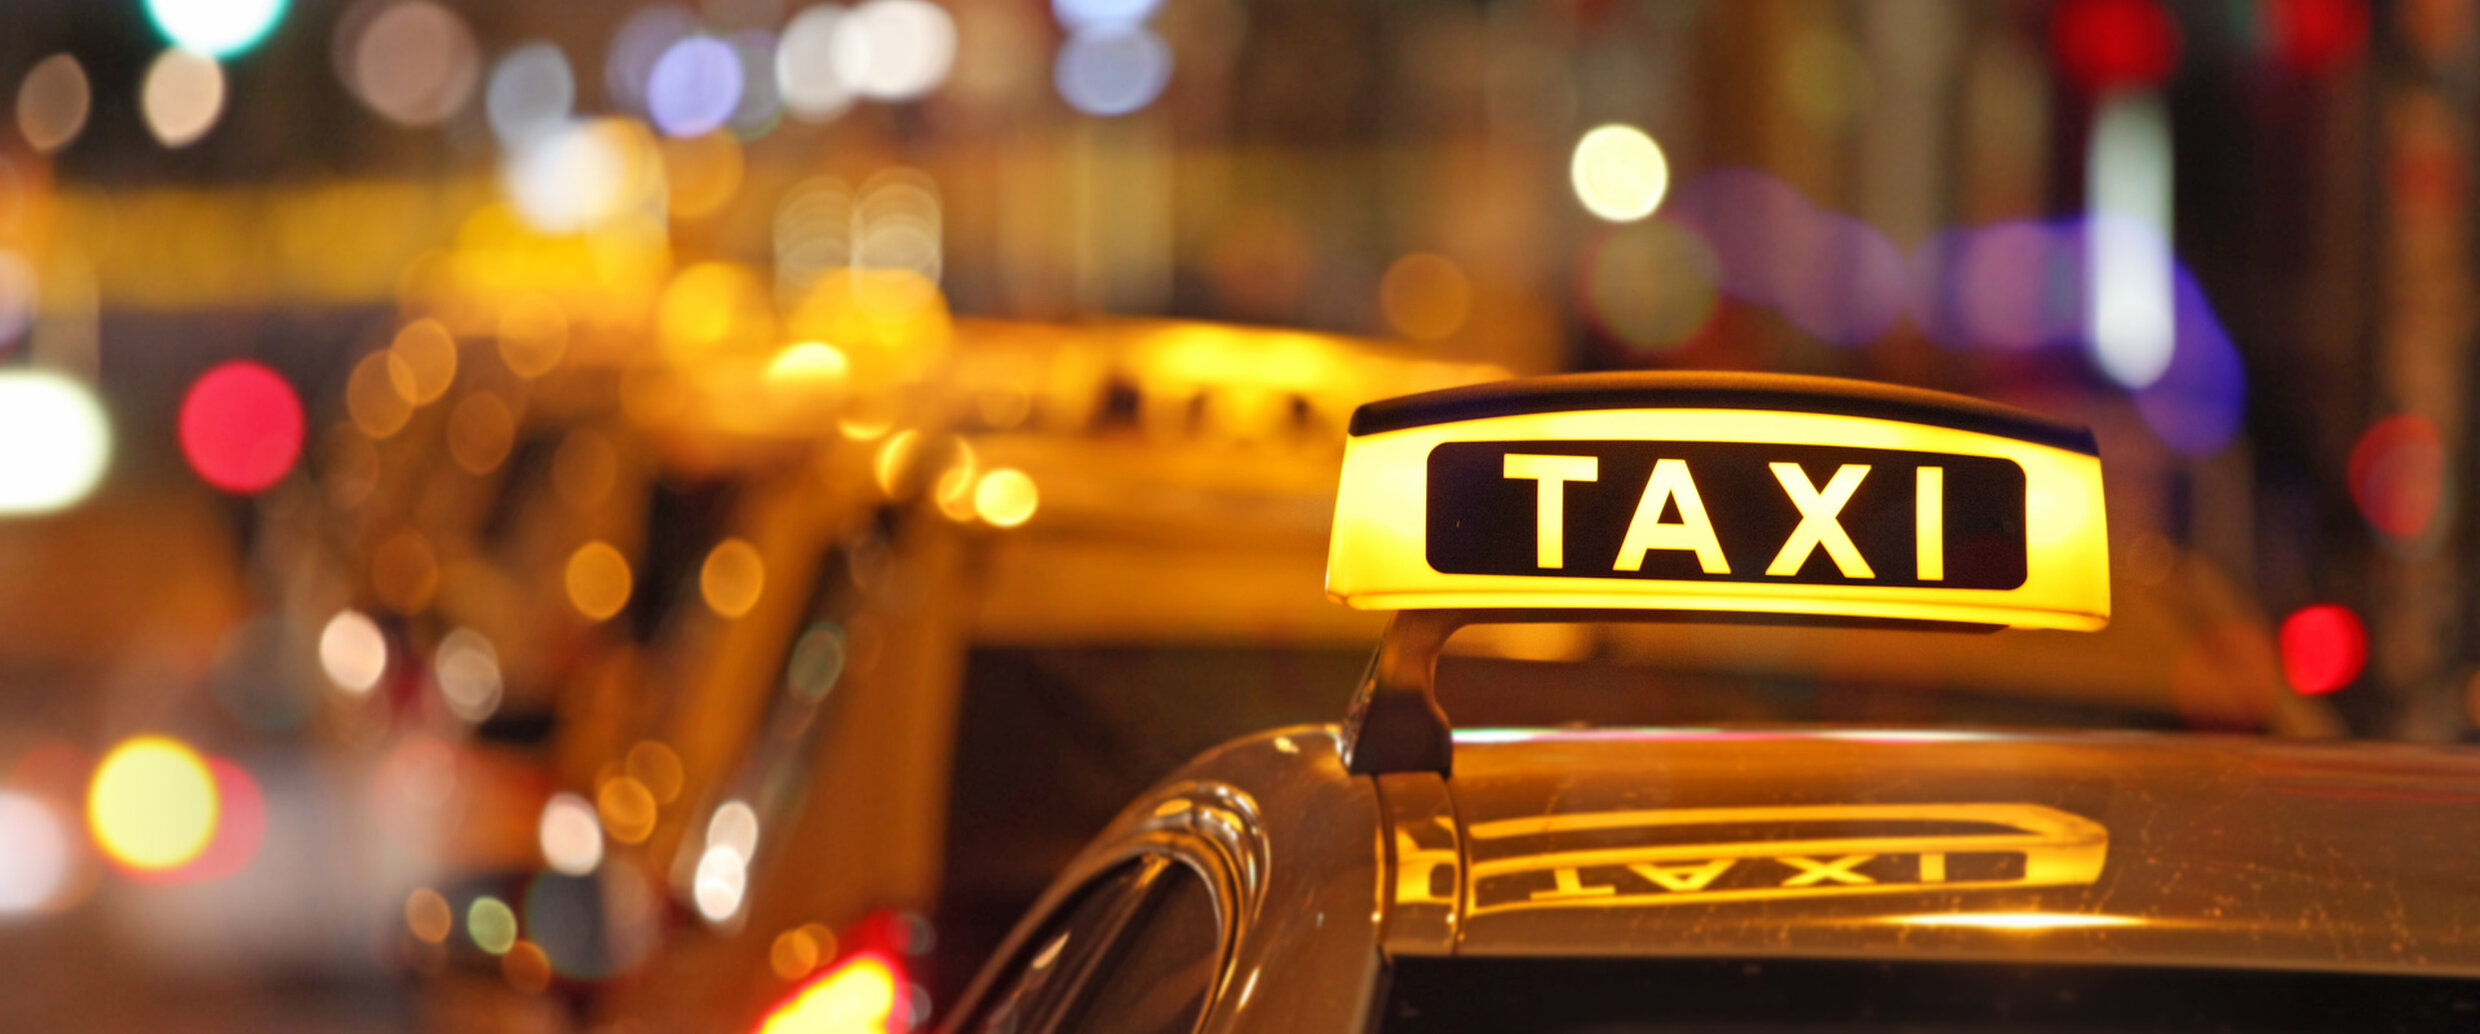

The Accurate Taxi company collects historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour.

Project progress:

- Loading and initial review of data.
- Data analysis.
- Train models with different hyperparameters.
- Checking data on a test sample
- General conclusion.

Objective of the project:

Build the best model. The *RMSE* metric on the test set should not exceed 48.

## Data preparation


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import torch.nn as nn
import torch

from torch import optim
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, cv, Pool, CatBoost

sns.set(color_codes=True)

In [6]:
data = pd.read_csv('C:\\Users\\Vadim\\data\\taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
display(data.info())
display(data.describe())
display(data.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


False    26496
dtype: int64

In [8]:
data.datetime = pd.to_datetime(data.datetime)

In [9]:
data = data.set_index('datetime')

In [10]:
data = data.sort_index()
data.index.is_monotonic

True

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Conclusion:**

The data is loaded and sorted by time. No gaps or duplicates found. The dataframe consists of two columns (date and number of orders) and 26496 rows. The data format is `object` and `int64`.

## Data analysis

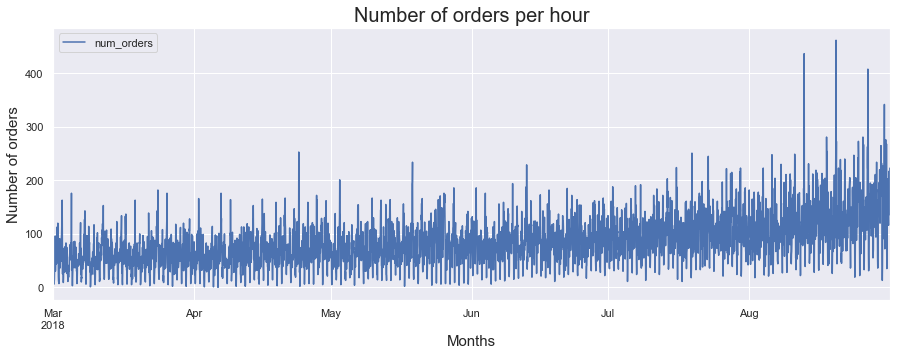

In [12]:
data.resample('1H').sum().plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Number of orders per hour', fontsize=20);

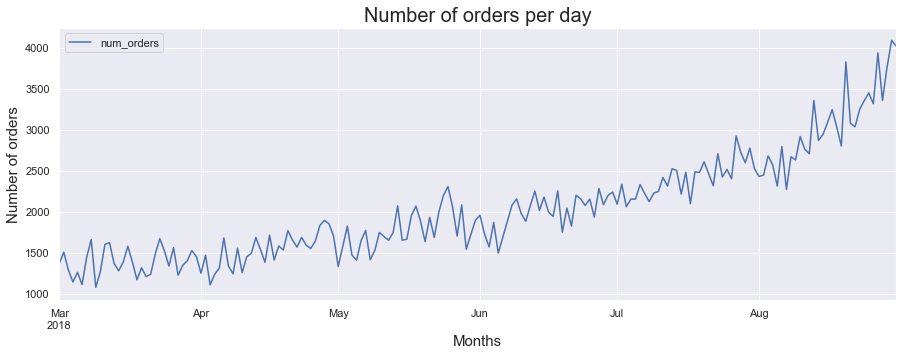

In [13]:
data.resample('1D').sum().plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Number of orders per day', fontsize=20);

The volume of daily orders is growing every month.

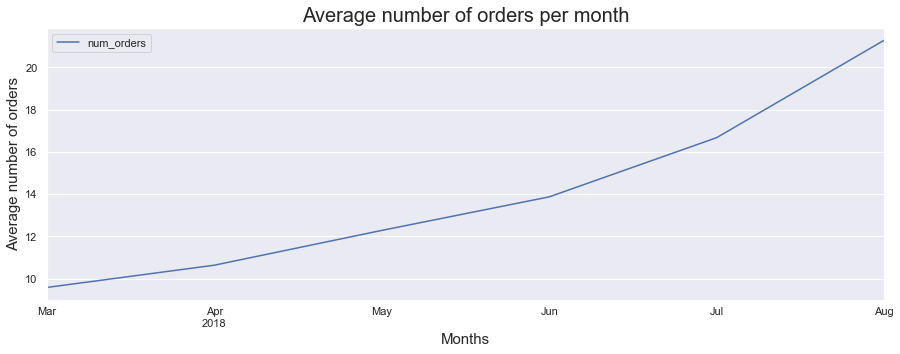

In [14]:
data_month_mean = data.resample('1M').mean()
data_month_mean.plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Average number of orders", fontsize=15)
plt.title('Average number of orders per month', fontsize=20);

The average number of orders per month shows growth.

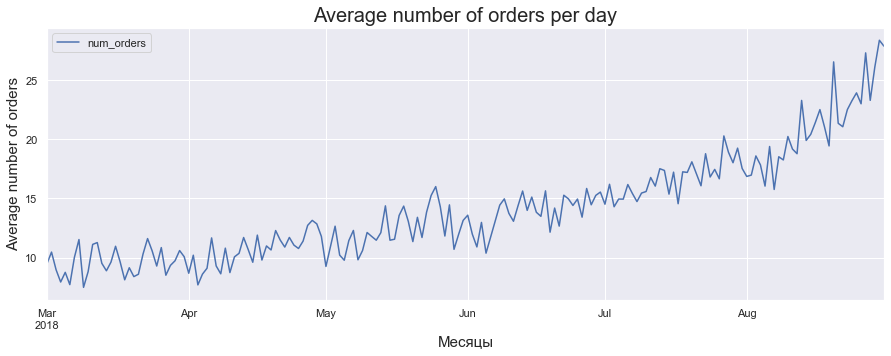

In [15]:
data_day_mean = data.resample('1D').mean()
data_day_mean.plot(figsize=(15, 5))
plt.xlabel("Месяцы", fontsize=15)
plt.ylabel("Average number of orders", fontsize=15)
plt.title('Average number of orders per day', fontsize=20);

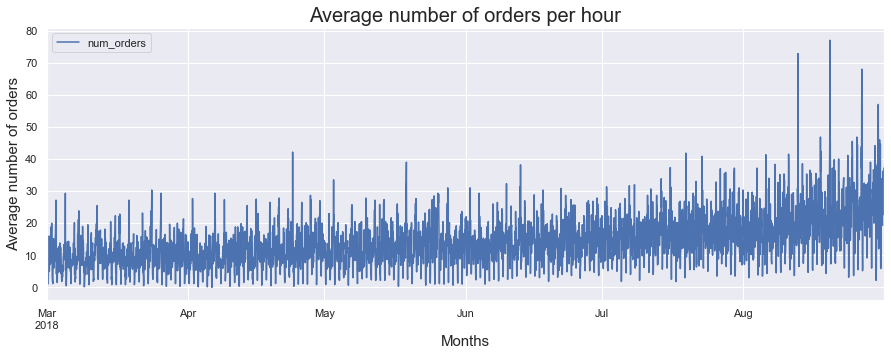

In [16]:
data_1h_mean = data.resample('1H').mean()
data_1h_mean.plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Average number of orders", fontsize=15)
plt.title('Average number of orders per hour', fontsize=20);

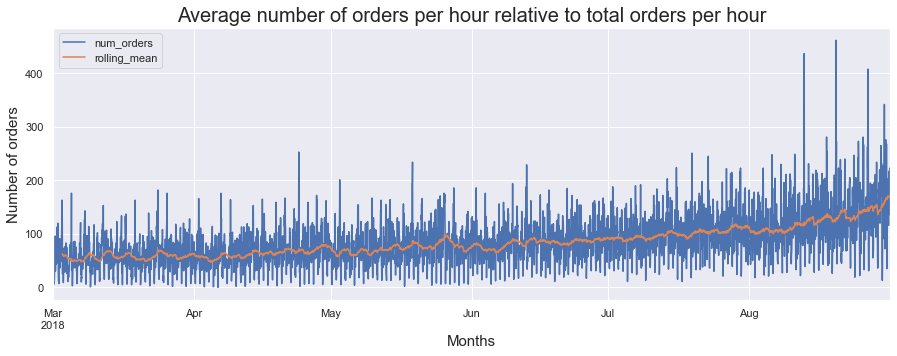

In [17]:
data_1h = data.resample('1H').sum()
data_1h['rolling_mean'] = data_1h.rolling(50).mean()  
data_1h.plot(figsize=(15, 5))
plt.xlabel("Months", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Average number of orders per hour relative to total orders per hour', fontsize=20);

All graphs show an increase in the number of orders over time. Here is a visualization of the average number of orders per hour versus the total orders per hour.

In [18]:
data = data.resample('1H').sum()

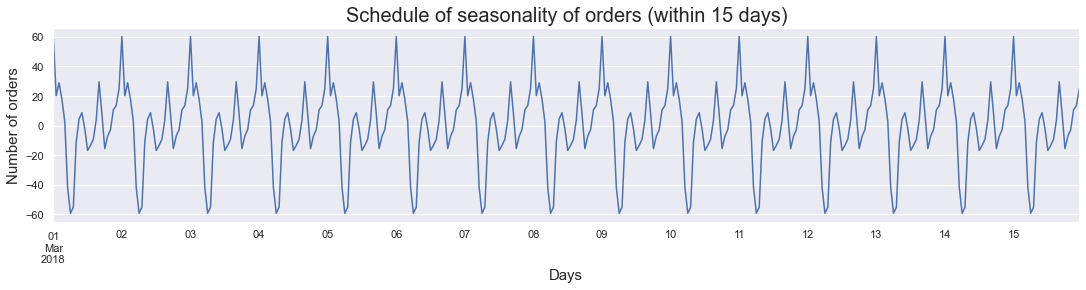

In [19]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-15 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Days", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Schedule of seasonality of orders (within 15 days)', fontsize=20);

On this chart it is difficult to tell about any regularities. It needs to increase the time interval.

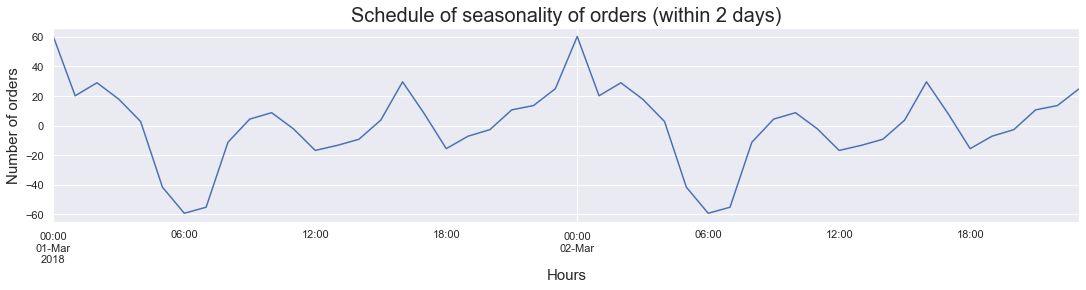

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(313)
plt.title('Seasonality')
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 23:59:59'].plot(ax=plt.gca())
plt.tight_layout()
plt.xlabel("Hours", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Schedule of seasonality of orders (within 2 days)', fontsize=20);

Here the patterns are already visible much better. The peak load occurs at midnight. At 6 am is the minimum. There is an average peak around 16:00 and a small one around 9 am.

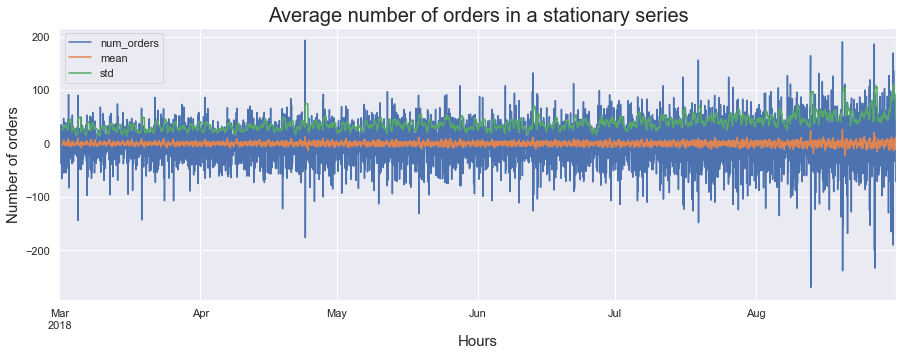

In [21]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(15).mean()
data_shift['std'] = data_shift['num_orders'].rolling(15).std()
data_shift.plot(figsize=(15, 5))
plt.xlabel("Hours", fontsize=15)
plt.ylabel("Number of orders", fontsize=15)
plt.title('Average number of orders in a stationary series', fontsize=20);

The graph shows how the mean and standard deviation increase over time. There are more outliers.

**Conclusion:**

The data analysis phase revealed a significant increase in the average number of orders over time. The maximum load is observed at 00:00. Minimum at 6:00. No anomalies were found.

## Training model

### Linear regression

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data_lag = data.copy()
    data_lag['year'] = data_lag.index.year
    data_lag['month'] = data_lag.index.month
    data_lag['day'] = data_lag.index.day
    data_lag['dayofweek'] = data_lag.index.dayofweek
    data_lag['hour'] = data_lag.index.hour
    
    for lag in range(1, max_lag + 1):
        data_lag['lag_{}'.format(lag)] = data_lag['num_orders'].shift(lag)

    data_lag['rolling_mean'] = data_lag['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_lag

In [23]:
%%time
best_max_lag = 0
best_rolling_mean_size = 0
best_rmse_cv = 1000

for max_lag in range(1, 100, 10):
    for rolling_mean_size in range(1, 100, 10):
        data_lag = make_features(data, max_lag, rolling_mean_size)
        
        train_lr, test_lr = train_test_split(data_lag, shuffle=False, test_size=0.1, random_state=35)
        train_lr = train_lr.dropna()
        
        X_train_lr = train_lr.drop(['num_orders'], axis=1)
        y_train_lr = train_lr['num_orders']

        X_test_lr = test_lr.drop(['num_orders'], axis=1)
        y_test_lr = test_lr['num_orders']
        
        model = LinearRegression()
        rmse_cv = np.mean((abs(cross_val_score(model, 
                                  X_train_lr, 
                                  y_train_lr, 
                                  cv=TimeSeriesSplit(n_splits=10), 
                                  scoring='neg_mean_squared_error')) ** 0.5))
        if rmse_cv < best_rmse_cv:
            best_rmse_cv = rmse_cv
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
print('RMSE', best_rmse_cv)
print('Max_lag (количество отстающих значений)', best_max_lag)
print('Rolling_mean_size (размер окна для вычисления среднего)', best_rolling_mean_size)

RMSE 25.429392710440236
Max_lag (количество отстающих значений) 41
Rolling_mean_size (размер окна для вычисления среднего) 51
Wall time: 7.63 s


### Neural net

In [24]:
%%time
best_rmse_valid = 1000
best_loss_list = None
best_rmse_list_train = None
best_rmse_list_valid = None
best_n_hidden_neurons_1 = None
best_n_hidden_neurons_2 = None
best_max_lag = None
best_rolling_mean_size = None

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)  
        
for max_lag in range(1, 100, 10):
    for rolling_mean_size in range(1, 100, 10):
        data_lag = make_features(data, max_lag, rolling_mean_size)
        
        train, sub_valid = train_test_split(data_lag, shuffle=False, test_size=0.2, random_state=35)
        valid, test = train_test_split(sub_valid, shuffle=False, test_size=0.5, random_state=35)
        train = train.dropna()
        
        X_train_ = train.drop(['num_orders'], axis=1)
        y_train_ = train['num_orders']
        
        X_valid_ = valid.drop(['num_orders'], axis=1)
        y_valid_ = valid['num_orders']

        X_test_ = test.drop(['num_orders'], axis=1)
        y_test_ = test['num_orders']
        
        X_train = torch.FloatTensor(X_train_.values)
        X_test = torch.FloatTensor(X_test_.values)
        X_valid = torch.FloatTensor(X_valid_.values)
        y_train = torch.FloatTensor(y_train_.values)
        y_test = torch.FloatTensor(y_test_.values)
        y_valid = torch.FloatTensor(y_valid_.values)
      
        for n_hidden_neurons_1 in [20, 40, 80]:
            for n_hidden_neurons_2 in [2, 4, 8]:
        
                n_in_neurons = X_valid_.shape[1]
                n_out_neurons = 1 

                net = nn.Sequential(
                    nn.Linear(n_in_neurons, n_hidden_neurons_1),
                    nn.ReLU(),
                    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
                    nn.ReLU(),
                    nn.Linear(n_hidden_neurons_2, n_out_neurons)
                )

                optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

                loss = nn.MSELoss()

                num_epochs = 100

                loss_list = []
                rmse_list_train = []
                rmse_list_valid = []
                
                for epoch in range(num_epochs):
    
                    optimizer.zero_grad()

                    preds_train = net.forward(X_train).flatten()
    
                    loss_value = loss(preds_train , y_train)

                    loss_value.backward()
      
                    optimizer.step()
    
                    loss_list.append(loss_value.detach().numpy()) 
    
                    RMSE_train = torch.sqrt(loss(preds_train, y_train)) 
    
                    rmse_list_train.append(RMSE_train.detach().numpy())
    
                    net.eval()
    
                    preds_valid = net.forward(X_valid).flatten()
    
                    RMSE_valid = torch.sqrt(loss(preds_valid, y_valid)) 
    
                    rmse_list_valid.append(RMSE_valid.detach().numpy())
    
                min_rmse_valid = min(rmse_list_valid)
        
                if best_rmse_valid > min_rmse_valid:
                    best_rmse_valid = min_rmse_valid 
                    best_loss_list = loss_list
                    best_rmse_list_train = rmse_list_train
                    best_rmse_list_valid = rmse_list_valid
                    best_n_hidden_neurons_1 = n_hidden_neurons_1
                    best_n_hidden_neurons_2 = n_hidden_neurons_2
                    best_max_lag = max_lag
                    best_rolling_mean_size = rolling_mean_size
            
for i in range(len(best_rmse_list_train)):
    if i % 10 == 0 or i == len(best_rmse_list_train) - 1:     
        print(best_rmse_list_train[i], best_rmse_list_valid[i], i)

56.859386 72.608475 0
33.06885 50.833275 10
31.197794 47.54104 20
28.717073 40.89075 30
25.461006 36.137203 40
23.84407 31.96946 50
22.900112 30.884285 60
22.38193 30.848948 70
22.002157 30.46932 80
21.75157 30.271833 90
21.623726 30.4076 99
Wall time: 2min 16s


In [25]:
hyperparameters_df = pd.DataFrame({'hyperparameters': ['n_hidden_neurons_1:', 'n_hidden_neurons_2:', 'max_lag:', 'rolling_mean_size:'],
              'value': [best_n_hidden_neurons_1, best_n_hidden_neurons_2, best_max_lag, best_rolling_mean_size]})
hyperparameters_df.style.set_properties(align="right")  

,hyperparameters,value
0,n_hidden_neurons_1:,40
1,n_hidden_neurons_2:,8
2,max_lag:,81
3,rolling_mean_size:,51


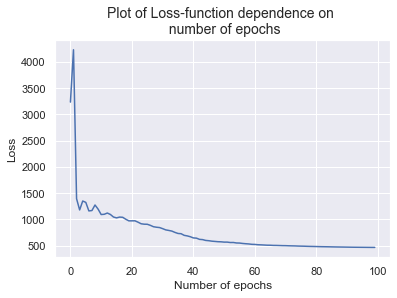

In [26]:
plt.plot(range(num_epochs), best_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title('Plot of Loss-function dependence on \n number of epochs', fontsize=14)
plt.show()

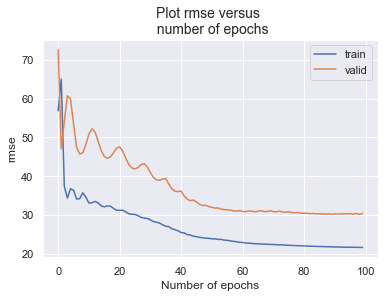

In [27]:
plt.plot(range(num_epochs), best_rmse_list_train)
plt.plot(range(num_epochs), best_rmse_list_valid)
plt.xlabel("Number of epochs")
plt.ylabel("rmse")
plt.legend(['train', 'valid'])
plt.title('Plot rmse versus \n number of epochs', fontsize=14)
plt.show() 

### Gradient boosting

In [ ]:
%%time

grid = {'iterations': [200, 400, 800],
        'learning_rate': [0.01, 0.02, 0.03],
        'depth': [4, 6, 8],
       }
model = CatBoostRegressor(grow_policy='SymmetricTree',
                           random_state=35,
                           verbose=1,
                           loss_function='RMSE', 
                           eval_metric='RMSE')

grid_search_result = model.grid_search(grid,                                    
                                       X=X_train_, 
                                       y=y_train_,
                                       cv=TimeSeriesSplit(n_splits=5),
                                       partition_random_seed=1,
                                       calc_cv_statistics=True,
                                       search_by_train_test_split=True,
                                       train_size=0.8,
                                       refit=True,
                                       verbose=False,
                                       plot=True)

In [ ]:
grid_search_result

### Evaluation of the quality of the forecast. Constant forecast.

A constant prediction shows how the model would predict if it gave random predictions. In this case, a constant model is created based on the median value. The model responses are replaced by the median value and compared with the real one.

In [30]:
pred_median = np.ones(pd.DataFrame(test.num_orders).shape) * train['num_orders'].median() 
print("RMSE:", (mean_squared_error(test['num_orders'], pred_median))**0.5)

RMSE: 88.64441651443998


**Conclusion:**

The fully connected neural network model gave the best result. Metric RMSE = 22.2, which is 4 times better than a random model.

## Testing the model

The neural network proved to be the best model

In [31]:

data_lag = make_features(data, best_max_lag, best_rolling_mean_size)
        
train, sub_valid = train_test_split(data_lag, shuffle=False, test_size=0.2, random_state=35)
valid, test = train_test_split(sub_valid, shuffle=False, test_size=0.5, random_state=35)
train = train.dropna()
valid = valid.dropna()
        
X_train_ = train.drop(['num_orders'], axis=1)
y_train_ = train['num_orders']
        
X_valid_ = valid.drop(['num_orders'], axis=1)
y_valid_ = valid['num_orders']

X_test_ = test.drop(['num_orders'], axis=1)
y_test_ = test['num_orders']
        
X_train = torch.FloatTensor(X_train_.values)
X_test = torch.FloatTensor(X_test_.values)
X_valid = torch.FloatTensor(X_valid_.values)
y_train = torch.FloatTensor(y_train_.values)
y_test = torch.FloatTensor(y_test_.values)
y_valid = torch.FloatTensor(y_valid_.values)

In [32]:
n_in_neurons = X_valid_.shape[1]
n_hidden_neurons_1 = best_n_hidden_neurons_1
n_hidden_neurons_2 = best_n_hidden_neurons_2
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

loss = nn.MSELoss()

num_epochs = 200

loss_list = []
rmse_list_train = []
rmse_list_test = []
                
for epoch in range(num_epochs):
    
    optimizer.zero_grad()

    preds_train = net.forward(X_train).flatten()
    
    loss_value = loss(preds_train , y_train)

    loss_value.backward()
      
    optimizer.step()
    
    loss_list.append(loss_value.detach().numpy()) 
    
    RMSE_train = torch.sqrt(loss(preds_train, y_train)) 
    
    rmse_list_train.append(RMSE_train.detach().numpy())
    
    net.eval()
    
    preds_test = net.forward(X_test).flatten()
    
    RMSE_test = torch.sqrt(loss(preds_test, y_test)) 
    
    rmse_list_test.append(RMSE_test.detach().numpy())
        
    if epoch % 10 == 0 or epoch == num_epochs - 1:     
        print(RMSE_train, RMSE_test, epoch)

tensor(115.9700, grad_fn=<SqrtBackward0>) tensor(136.3483, grad_fn=<SqrtBackward0>) 0
tensor(33.8737, grad_fn=<SqrtBackward0>) tensor(63.8728, grad_fn=<SqrtBackward0>) 10
tensor(32.6744, grad_fn=<SqrtBackward0>) tensor(59.3478, grad_fn=<SqrtBackward0>) 20
tensor(32.4758, grad_fn=<SqrtBackward0>) tensor(64.8764, grad_fn=<SqrtBackward0>) 30
tensor(31.9463, grad_fn=<SqrtBackward0>) tensor(56.5475, grad_fn=<SqrtBackward0>) 40
tensor(31.0750, grad_fn=<SqrtBackward0>) tensor(59.0766, grad_fn=<SqrtBackward0>) 50
tensor(30.1503, grad_fn=<SqrtBackward0>) tensor(56.7220, grad_fn=<SqrtBackward0>) 60
tensor(29.2148, grad_fn=<SqrtBackward0>) tensor(53.6260, grad_fn=<SqrtBackward0>) 70
tensor(28.0129, grad_fn=<SqrtBackward0>) tensor(51.6324, grad_fn=<SqrtBackward0>) 80
tensor(26.6312, grad_fn=<SqrtBackward0>) tensor(49.1743, grad_fn=<SqrtBackward0>) 90
tensor(25.2808, grad_fn=<SqrtBackward0>) tensor(46.3846, grad_fn=<SqrtBackward0>) 100
tensor(24.2048, grad_fn=<SqrtBackward0>) tensor(44.2761, grad_f

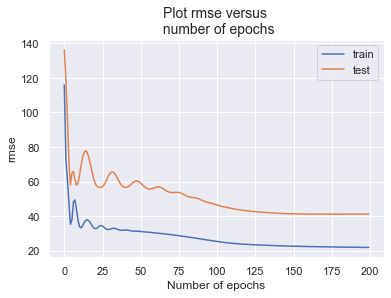

In [33]:
plt.plot(range(num_epochs), rmse_list_train)
plt.plot(range(num_epochs), rmse_list_test)
plt.xlabel("Number of epochs")
plt.ylabel("rmse")
plt.legend(['train', 'test'])
plt.title('Plot rmse versus \n number of epochs', fontsize=14)
plt.show() 

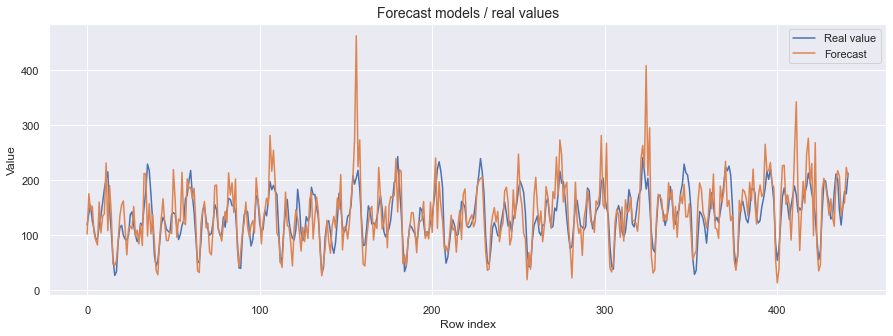

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(range(len(preds_test.detach().numpy())), preds_test.detach().numpy())
plt.plot(range(len(y_test.detach().numpy())), y_test.detach().numpy())
plt.xlabel("Row index")
plt.ylabel("Value")
plt.legend(['Real value', 'Forecast'])
plt.title('Forecast models / real values', fontsize=14)
plt.show() 

Based on the graph, it can be seen how, in general, the model guesses the trend, although some outliers are still present. Nevertheless, it can be stated that the seasonality curve of the model is similar to the seasonality curve of real values.

## General conclusion

During this project, a statistical analysis of the data was performed.

As a result of the analysis, hours of peak load (00:00) and minimum (6:00) were established. A steady increase in the number of orders over time was also found.

3 models were trained. Linear regression, neural network and gradient boosting. The best result was shown by a neural network with an RMSE value on a validation set of 30.3. Linear regression and boosting 25.4 and 25.1 respectively.


The best RMSE on the test sample was 41.06. Which is less than required by 15%.